## import

In [1]:
# !pip install -U --no-cache-dir pandas transformers matplotlib seaborn tqdm


In [2]:
import pandas as pd
import os
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# (tqdmをpandasで使えるように設定)
tqdm.pandas()
print("Libraries imported.")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


Libraries imported.


In [6]:
# --- 1. 設定 ---

# 訓練データセットのパス
TRAINING_FILE = "data/processed/training_dataset_abstract.csv"

# 使用するベースモデル（SciBERT）
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# トークナイザのロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print("Tokenizer loaded.")

Tokenizer loaded.


In [7]:
# --- 2. データセットの読み込み ---
print("Loading dataset...")
df = pd.read_csv(TRAINING_FILE)
df = df.dropna(subset=['abstract_a', 'abstract_b'])

# abstract_a と abstract_b の両方の列から、重複しないアブストラクトのリストを作成
all_abstracts = pd.concat([df['abstract_a'], df['abstract_b']]).unique()
df_abstracts = pd.DataFrame(all_abstracts, columns=['abstract'])

print(f"Loaded {len(df)} pairs, containing {len(df_abstracts)} unique abstracts.")

Loading dataset...
Loaded 35315 pairs, containing 29496 unique abstracts.


## アブストラクトの長さをチェック

In [8]:
# --- 3. 各ユニークなアブストラクトのトークン長を計算 ---

def count_single_token(text):
    # [CLS] text [SEP] の形式でトークン化し、長さを返す
    # (add_special_tokens=True はデフォルトで有効)
    tokenized = tokenizer(text)
    return len(tokenized['input_ids'])

print("Calculating token lengths for all unique abstracts (this may take a moment)...")
# .progress_applyで進捗バーを表示しながら計算
df_abstracts['token_length'] = df_abstracts['abstract'].progress_apply(count_single_token)

print("Token length calculation complete.")

Calculating token lengths for all unique abstracts (this may take a moment)...


  0%|          | 0/29496 [00:00<?, ?it/s]

Token length calculation complete.


In [9]:
# --- 4. 分析結果の表示 ---
MAX_LENGTH = 512

print("\n--- Single Abstract Token Length Statistics ---")
display(df_abstracts['token_length'].describe())

# 512トークンを超えるアブストラクトの割合を計算
truncated_count = (df_abstracts['token_length'] > MAX_LENGTH).sum()
total_count = len(df_abstracts)
percentage = (truncated_count / total_count) * 100

print("\n" + "="*50)
print(f"   Max Length (Truncation limit): {MAX_LENGTH} tokens")
print(f"Abstracts EXCEEDING max length: {truncated_count:,} / {total_count:,}")
print(f"Percentage of abstracts to be truncated: {percentage:.2f}%")
print("="*50)


--- Single Abstract Token Length Statistics ---


count    29496.000000
mean       312.368186
std        248.319169
min         13.000000
25%        181.000000
50%        267.000000
75%        370.000000
max       8274.000000
Name: token_length, dtype: float64


   Max Length (Truncation limit): 512 tokens
Abstracts EXCEEDING max length: 2,940 / 29,496
Percentage of abstracts to be truncated: 9.97%



--- Single Abstract Token Length Distribution ---


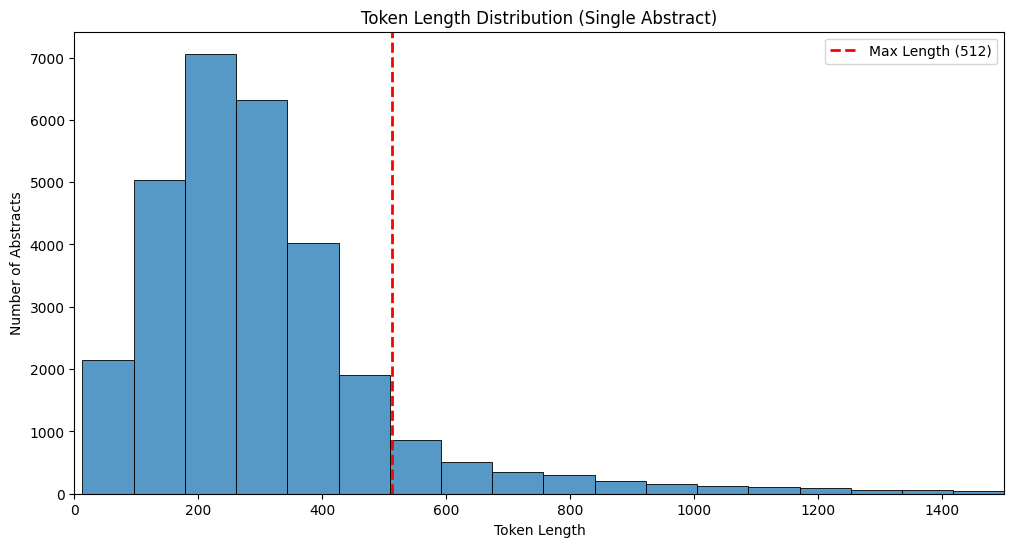

In [10]:
# --- 5. 分布の可視化 ---
print("\n--- Single Abstract Token Length Distribution ---")

plt.figure(figsize=(12, 6))
sns.histplot(df_abstracts['token_length'], bins=100, kde=False)

# 512トークンの位置に赤い線を引く
plt.axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')

plt.title('Token Length Distribution (Single Abstract)')
plt.xlabel('Token Length')
plt.ylabel('Number of Abstracts')
plt.legend()
# X軸の範囲を、例えば1000トークンまでに制限すると見やすくなります
plt.xlim(0, 1500)
plt.show()

## アブストラクトのペアの長さをチェック

In [11]:
# --- 3. 各ペアのトークン長を計算 ---

def count_tokens(row):
    # tokenizer(A, B) は [CLS] A [SEP] B [SEP] の形式で
    # トークン化し、特殊トークンも自動で含めます。
    tokenized = tokenizer(row["abstract_a"], row["abstract_b"])
    # input_idsの長さが、モデルに入力される最終的なトークン数です。
    return len(tokenized['input_ids'])

print("Calculating token lengths for all pairs (this may take a moment)...")
# .progress_applyで進捗バーを表示しながら計算
df['token_length'] = df.progress_apply(count_tokens, axis=1)

print("Token length calculation complete.")

Calculating token lengths for all pairs (this may take a moment)...


  0%|          | 0/35315 [00:00<?, ?it/s]

Token length calculation complete.


In [12]:
# --- 4. 分析結果の表示 ---
MAX_LENGTH = 512

print("\n--- Token Length Statistics ---")
display(df['token_length'].describe())

# 512トークンを超えるペアの割合を計算
truncated_count = (df['token_length'] > MAX_LENGTH).sum()
total_count = len(df)
percentage = (truncated_count / total_count) * 100

print("\n" + "="*50)
print(f"   Max Length (Truncation limit): {MAX_LENGTH} tokens")
print(f"Pairs EXCEEDING max length: {truncated_count:,} / {total_count:,}")
print(f"Percentage of pairs to be truncated: {percentage:.2f}%")
print("="*50)


--- Token Length Statistics ---


count    35315.000000
mean       714.858644
std        459.690431
min         48.000000
25%        454.000000
50%        603.000000
75%        807.000000
max       9080.000000
Name: token_length, dtype: float64


   Max Length (Truncation limit): 512 tokens
Pairs EXCEEDING max length: 23,213 / 35,315
Percentage of pairs to be truncated: 65.73%



--- Token Length Distribution Histogram ---


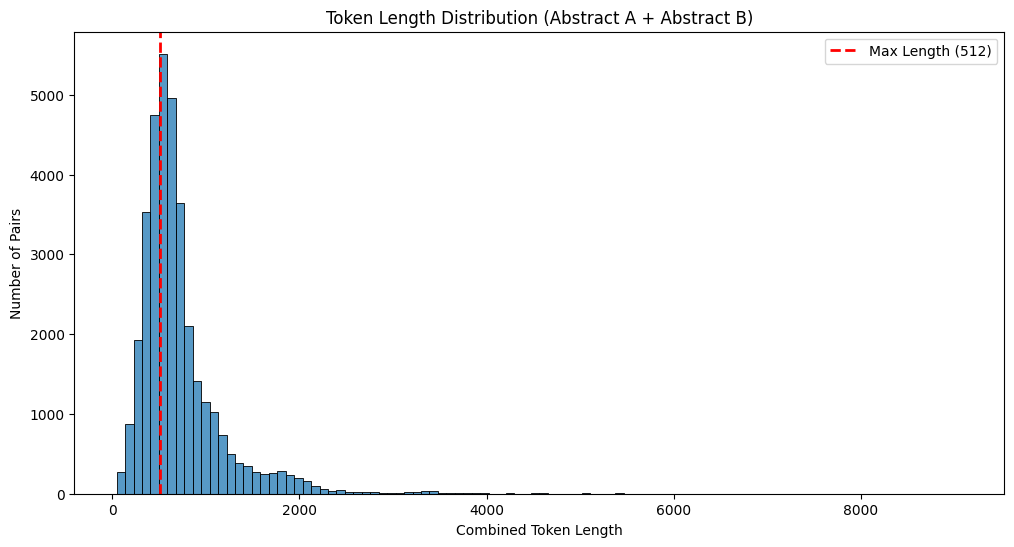

In [13]:
# --- 5. 分布の可視化 ---
print("\n--- Token Length Distribution Histogram ---")

plt.figure(figsize=(12, 6))
sns.histplot(df['token_length'], bins=100, kde=False)

# 512トークンの位置に赤い線を引く
plt.axvline(MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LENGTH})')

plt.title('Token Length Distribution (Abstract A + Abstract B)')
plt.xlabel('Combined Token Length')
plt.ylabel('Number of Pairs')
plt.legend()
plt.show()

## 長いアブストラクトの処理

In [16]:
# --- 4. 長いアブストラクトの調査 ---
import textwrap
from IPython.display import display, HTML
print(f"\n--- Inspecting abstracts longer than {MAX_LENGTH} tokens ---")

# 512トークンを超えるアブストラクトを抽出
df_long = df_abstracts[df_abstracts['token_length'] > MAX_LENGTH].sort_values(by='token_length', ascending=False)

# 最も長い5件を表示
for index, row in df_long.head(5).iterrows():
    print("\n" + "="*80)
    print(f"Rank {index+1}: Token Length = {row['token_length']}")
    print("="*80)

    # HTMLでラップして、スクロール可能なボックスで表示
    display_html = f"""
    <div style="border: 1px solid #ccc; padding: 10px; background: #f9f9f9; height: 300px; overflow-y: scroll; font-family: monospace;">
        <b>--- START OF ABSTRACT (first 500 chars) ---</b><br>
        {textwrap.shorten(row['abstract'], width=500, placeholder='...')}
        <br><br>... (content truncated) ...<br><br>
        <b>--- END OF ABSTRACT (last 500 chars) ---</b><br>
        ...{textwrap.shorten(row['abstract'][::-1], width=500, placeholder='...')[::-1]}
    </div>
    """
    display(HTML(display_html))


--- Inspecting abstracts longer than 512 tokens ---

Rank 13573: Token Length = 8274



Rank 13776: Token Length = 6856



Rank 27506: Token Length = 6267



Rank 1605: Token Length = 5002



Rank 15130: Token Length = 4960
